カーネル法を用いたサポートベクタマシン
-------------------------
- 線形サポートベクタマシンを拡張し、より複雑なモデルを可能としたもの
- クラス分類にも回帰にも利用できる

In [8]:
from IPython.display import set_matplotlib_formats, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
from cycler import cycler
from sklearn.model_selection import train_test_split
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

線形モデルと非線形特徴量
--------------------
- 低次元における線形モデルは非常に制約がつよい
    - 直線や超平面が柔軟性を制限するため
    - (直線で表現できる特徴量は2つで、直線だけで分類するのは難しい)
- 線形モデルを柔軟にする方法の一つが「特徴量を追加する」こと

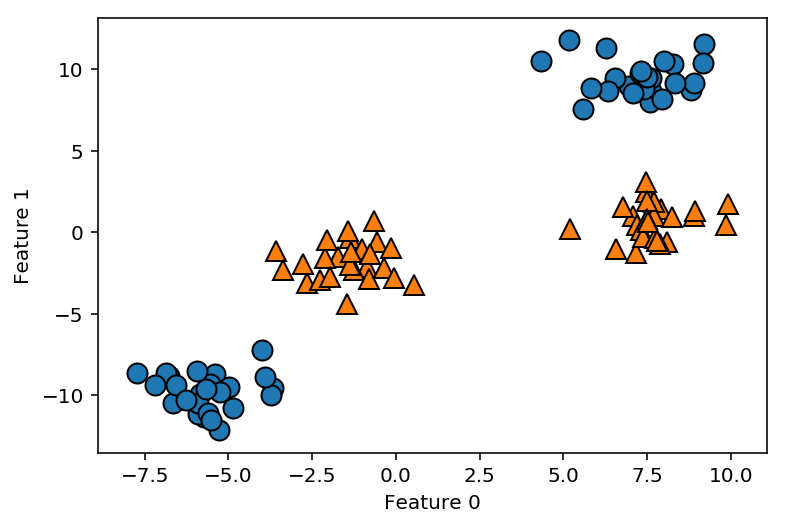

In [9]:
from sklearn.datasets import make_blobs
X, y = make_blobs(centers=4, random_state=8)
y = y %2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

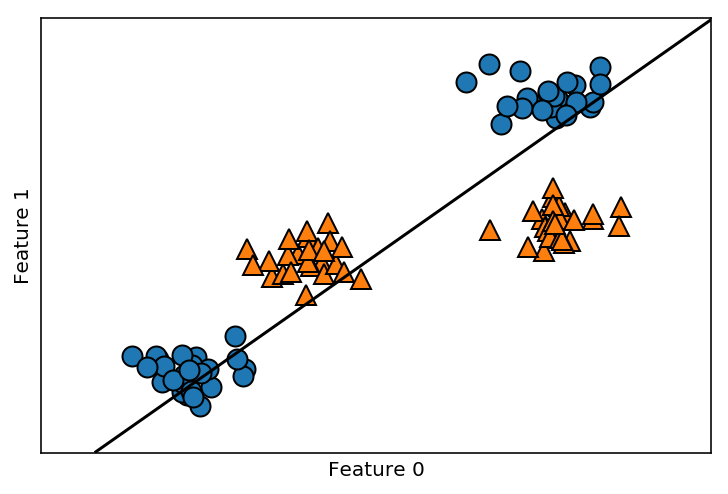

In [10]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

- 線形モデルによるクラス分類では、直線で分離することしかできないため、このようなデータセットではうまくいかない

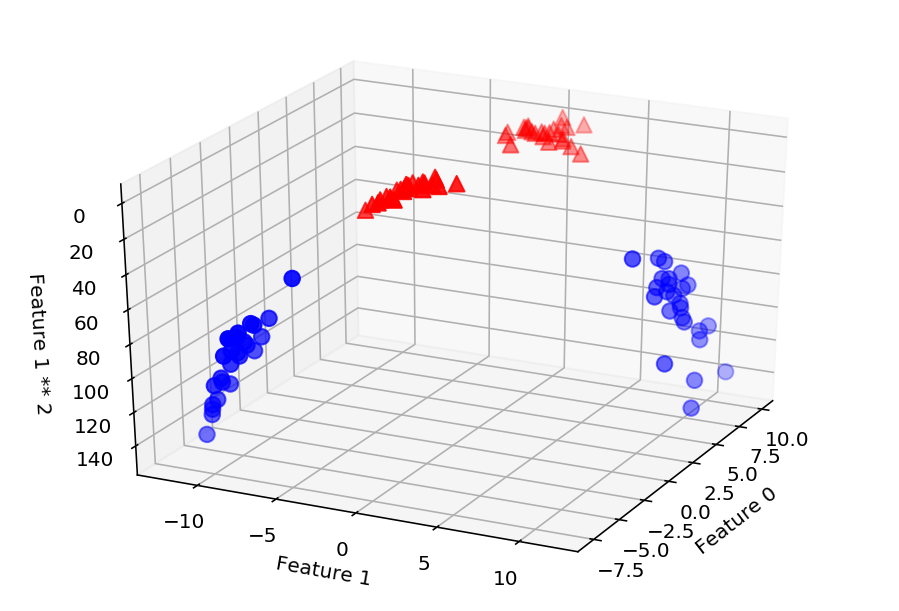

In [31]:
# 2番目の特徴量の2乗を追加
X_new = np.hstack([X, X[:, 1:] ** 2])

from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()

# 3dで可視化
ax = Axes3D(figure, elev=-152, azim=-26)
# y == 0の点をプロットしてから y==1の点をプロット
mask = y == 0
ax.scatter(X_new[mask,  0], X_new[mask,  1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask,  0], X_new[~mask,  1], X_new[~mask, 2], c='r', cmap=mglearn.cm2, marker='^', s=60)

ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")
ax.set_zlabel("Feature 1 ** 2")

- 特徴量を拡張する
- 例えば feature1 ** 2 つまり2番目の特徴量の2乗を新しい特徴量として追加してみる

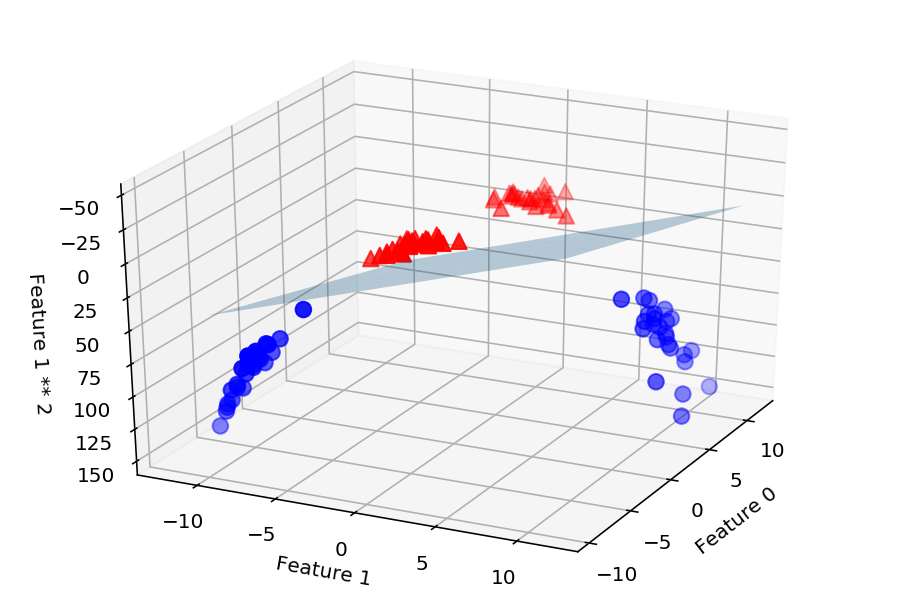

In [32]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# 線形決定境界を描画
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)

ax.scatter(X_new[mask,  0], X_new[mask,  1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask,  0], X_new[~mask,  1], X_new[~mask, 2], c='r', cmap=mglearn.cm2, marker='^', s=60)

ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")
ax.set_zlabel("Feature 1 ** 2")

- この新しい表現では2つのクラスを線形モデルで、つまり３次元空間内の平面を用いて分離することが可能

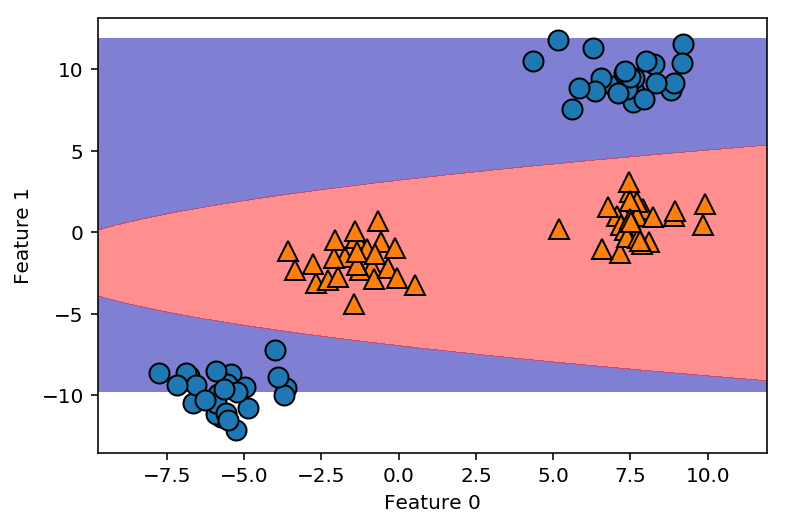

In [36]:
ZZ = YY ** 2
# 一次元で表現
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

- もとの特徴量の関数として見ると線形SVMモデルは線形ではなくなっている
- 直線ではなく楕円に近くなっている

### カーネルトリック
- 非線形の特徴量をデータ表現に加えることで線形モデルがはるかに強力になる
- しかし、実際にはどの特徴量を加えたらよいかわからない
    - たくさんの特徴量を加えると計算量が多すぎる
- これを解決するために、非常に大きくなりうる表現を実際には計算せずに高次元空間でのクラス分類機を学習させる数学的トリックが存在する。これを「カーネルトリック(kernel trick)」という
- サポートベクタマシンで広く用いられている高次元空間へのマップ方法は2つある
    - 1.もとの特徴量の特定の次数までの全ての多項式(feature1 ** 2 * feature2 ** 5など)を計算する「多項式カーネル(polynomial kernel)」
    - 2.放射基底関数(radial basis function: RBF)カーネルともよばれる「ガウシアンカーネル」

### SVNの理解
- SVMは個々のデータポイントが2つのクラスの決定境界を表現するのにどの程度重要かを学習する
- 多くの場合2つのクラスの境界に位置するごく一部の訓練データポイントだけが決定境界を決定する
    - これらのデータポイントを「サポートベクタ(support vector)」と呼ぶ
- 新しデータポインタに対して予測を行う際に、サポートベクタとデータポインタとの距離が測定される
    - クラス分類はこのサポートベクタとの距離と訓練過程で学習された`個々のサポートベクタの重要性※`によって決定される
        - ※ SVCのdual_coef_属性に格納される

#### 2次元2クラス分類データセットに対してサポートベクタマシンを学習させた結果

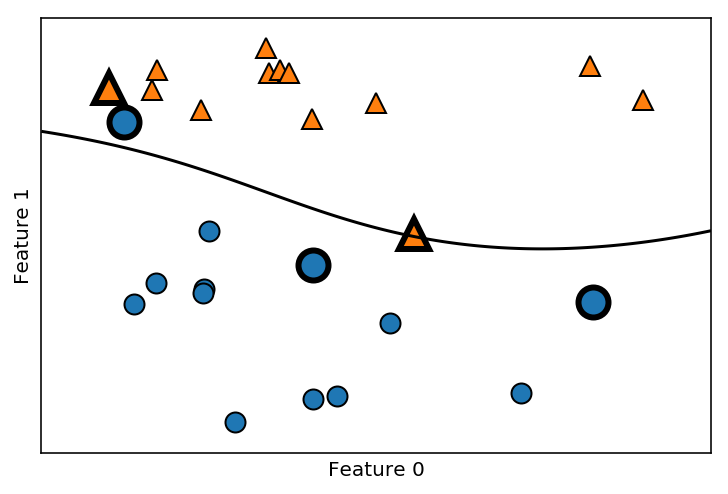

In [46]:
from sklearn.svm import SVC
X, y = mglearn.tools.make_handcrafted_dataset()
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
# サポートベクタをプロットする
sv = svm.support_vectors_
# サポートベクタのクラスラベルはdual_coef_の正負によって与えられる
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)

plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

- この場合SVMによる境界は非線形(直線ではない)でありなめらか

### SVMのパラメータの調整
- gammmaパラメータはガウシアンカーネルの幅を調整する
    - このパラメータが点が近いということを意味するスケールを決定する
- Cパラメータは線形モデルで用いられたのと同様の正則化パラメタ
    - 個々のデータポイントの重要度(データポインタのdual_coef_)を制限する